In [14]:
import os

import pandas as pd

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm

In [15]:
prefixes = ['bitonic', 'simple']

In [16]:
main_dfs = []
for prefix in prefixes:
    curr_df = pd.read_csv(os.path.join(prefix, 'table.csv'), index_col=0)
    curr_df['prefix'] = prefix.split('_')[0]
    main_dfs.append(curr_df)
df_main = pd.concat(main_dfs, axis=0, ignore_index=True).reset_index()

df_main

,index,name,syncs,max_syncs,reads,writes,ops,full_ops,sync_points,cache-misses,cache-references,l2_rqsts.all_demand_miss,l2_rqsts.all_demand_references,mean_of_cache_miss_ratios,mean_of_L2_miss_ratios,nprs_mean,nprs_ci,prefix
0,0,1_stock_4,[0],0,[320],[160],[[]],[[]],[[]],1.237751e+05,5.057064e+07,1.215505e+07,1.351177e+08,0.002455,0.090042,21.605499,0.412649,bitonic
1,1,1_depth_4,[11],11,[320],[176],"[[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]]","[[0, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]]","[[[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, ...",1.189731e+05,4.542342e+07,1.101420e+07,1.199235e+08,0.002625,0.091868,22.357325,0.510684,bitonic
2,2,2_depth_4,"[11, 11]",11,"[160, 160]","[88, 88]","[[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], [8, 8, 8, ...","[[0, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16], ...","[[[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, ...",1.233114e+05,7.463880e+07,1.678353e+07,1.154359e+08,0.001653,0.145411,39.737131,0.690140,bitonic
3,3,4_depth_4,"[11, 11, 11, 11]",11,"[80, 80, 80, 80]","[44, 44, 44, 44]","[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, ...","[[0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], [0, 8, 8, ...","[[[4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, ...",6.691776e+04,1.304953e+08,2.812413e+07,1.444991e+08,0.000514,0.194690,57.794763,0.641862,bitonic
4,4,1_stock_5,[0],0,[960],[480],[[]],[[]],[[]],4.936986e+04,4.616297e+07,1.107683e+07,1.353916e+08,0.001073,0.081886,7.297853,0.148959,bitonic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,87,1_depth_131072,[21],21,[5242880],[2752512],"[[131072, 131072, 131072, 131072, 131072, 1310...","[[0, 262144, 262144, 262144, 262144, 262144, 2...","[[[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, ...",3.175467e+08,2.366044e+09,7.439259e+08,5.532977e+09,0.134288,0.134426,1.531901,0.047628,simple
88,88,2_stock_131072,"[2, 2]",2,"[2621440, 2621440]","[1376256, 1376256]","[[231, 1375815], [231, 1375815]]","[[420, 2620600], [420, 2620600]]","[[[1, 1], [1, 1]], [[1, 1], [1, 1]]]",4.696407e+08,5.091197e+08,2.296126e+08,2.643389e+08,0.922507,0.868613,1.059307,0.021344,simple
89,89,2_depth_131072,"[21, 21]",21,"[2621440, 2621440]","[1376256, 1376256]","[[65536, 65536, 65536, 65536, 65536, 65536, 65...","[[0, 131072, 131072, 131072, 131072, 131072, 1...","[[[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, ...",4.339592e+08,1.238911e+09,7.531673e+08,1.037938e+09,0.350174,0.725596,1.121370,0.016289,simple
90,90,4_stock_131072,"[2, 2, 2, 2]",2,"[1310720, 1310720, 1310720, 1310720]","[688128, 688128, 688128, 688128]","[[231, 687687], [231, 687687], [231, 687687], ...","[[420, 1309880], [420, 1309880], [420, 1309880...","[[[1, 1], [1, 1]], [[1, 1], [1, 1]], [[1, 1], ...",4.972442e+08,5.329262e+08,2.452080e+08,2.791543e+08,0.933041,0.878362,1.000125,0.008222,simple


In [17]:
df = df_main.copy()

# df['mean_cache_misses_to_mean_cache_refs'] = df['промахи ср'] / df['исп кэша ср']
# df['mean_L2_misses_to_mean_L2_refs'] = df['промахи L2 ср'] / df['исп L2 ср']
df['threads'] = df['reads'].apply(lambda x: len(eval(x)))
df['threads_inverse'] = 1. / df['threads']
df['reads'] = df['reads'].apply(lambda x: sum(eval(x)))
df['writes'] = df['writes'].apply(lambda x: sum(eval(x)))
df['reads_ratio'] = df['reads'] / (df['reads'] + df['writes'])
df['operations'] = df['reads'] + df['writes']
df['algo'] = df['name'].str.split('_', expand=True).loc[:, 1]
df['graph_width'] = df['name'].str.split('_', expand=True).loc[:, 2]
df['graph_type'] = df['prefix']
df['nprs_mean_weighted'] = df['nprs_mean'] * df['threads']
df['log_nprs_mean_weighted'] = np.log(df['nprs_mean_weighted'])
df['total_syncs'] = df['syncs'].apply(lambda x: sum(eval(x)))
df['mean_syncs'] = df['syncs'].apply(lambda x: np.mean(eval(x)))

In [18]:
X_keys = ['operations', 'threads', 'reads', 'writes', 'max_syncs', 'mean_of_cache_miss_ratios', 'mean_of_L2_miss_ratios']
# y_key = 'log_nprs_mean_weighted'
y_key = 'nprs_mean_weighted'
# y_key = 'nprs_mean'
help_keys = ['graph_type', 'graph_width', 'algo', 'name'] + (['nprs_mean'] if y_key != 'nprs_mean' else []) + (['threads'] if 'threads' not in X_keys else [])

Xy_keys = X_keys + [y_key]

In [19]:
df = df[help_keys + X_keys + [y_key]]

df

,graph_type,graph_width,algo,name,nprs_mean,operations,threads,reads,writes,max_syncs,mean_of_cache_miss_ratios,mean_of_L2_miss_ratios,nprs_mean_weighted
0,bitonic,4,stock,1_stock_4,21.605499,480,1,320,160,0,0.002455,0.090042,21.605499
1,bitonic,4,depth,1_depth_4,22.357325,496,1,320,176,11,0.002625,0.091868,22.357325
2,bitonic,4,depth,2_depth_4,39.737131,496,2,320,176,11,0.001653,0.145411,79.474262
3,bitonic,4,depth,4_depth_4,57.794763,496,4,320,176,11,0.000514,0.194690,231.179052
4,bitonic,5,stock,1_stock_5,7.297853,1440,1,960,480,0,0.001073,0.081886,7.297853
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,simple,131072,depth,1_depth_131072,1.531901,7995392,1,5242880,2752512,21,0.134288,0.134426,1.531901
88,simple,131072,stock,2_stock_131072,1.059307,7995392,2,5242880,2752512,2,0.922507,0.868613,2.118614
89,simple,131072,depth,2_depth_131072,1.121370,7995392,2,5242880,2752512,21,0.350174,0.725596,2.242739
90,simple,131072,stock,4_stock_131072,1.000125,7995392,4,5242880,2752512,2,0.933041,0.878362,4.000501


100%|██████████| 200/200 [00:01<00:00, 120.25it/s]


nprs_mean_th: 1.6027638190954774
MPE: 0.25228814491803747
MAE: 0.4631293117413759
train: 0.5760869565217391
test: 0.2608695652173913
train + test: 0.8369565217391304


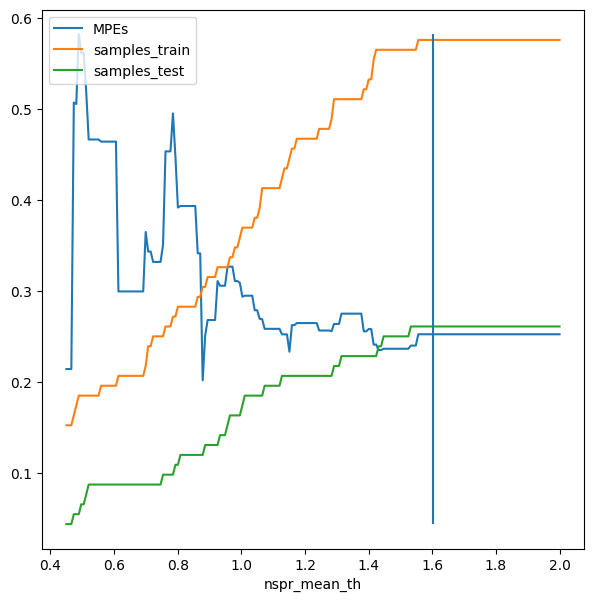

In [36]:
threads = [1, 2, 4]

ths = np.linspace(start=0.45, stop=2, num=200)
mpes = []
maes = []
samples_train = []
samples_test = []
models = []
for nprs_mean_th in tqdm(ths):
    X_train = df.loc[((df['algo'] == 'stock') & (df['graph_type'] == 'simple')) | (df['graph_type'] == 'bitonic')].loc[df['nprs_mean'] <= nprs_mean_th].loc[df['threads'].isin(threads)][X_keys].to_numpy()
    y_train = df.loc[((df['algo'] == 'stock') & (df['graph_type'] == 'simple')) | (df['graph_type'] == 'bitonic')].loc[df['nprs_mean'] <= nprs_mean_th].loc[df['threads'].isin(threads)][y_key].to_numpy()

    X_test = df.loc[(df['algo'] == 'depth') & (df['graph_type'] == 'simple')].loc[df['nprs_mean'] <= nprs_mean_th].loc[df['threads'].isin(threads)][X_keys].to_numpy()
    y_test = df.loc[(df['algo'] == 'depth') & (df['graph_type'] == 'simple')].loc[df['nprs_mean'] <= nprs_mean_th].loc[df['threads'].isin(threads)][y_key].to_numpy()

    # print(X_train.shape)
    # print(X_test.shape)

    model_cross = LinearRegression()
    model_cross.fit(X=X_train, y=y_train)

    models.append(model_cross)

    y_pred = model_cross.predict(X_test)

    mpes.append(np.mean(np.abs((y_pred - y_test) / y_test)))
    maes.append(np.mean(np.abs((y_pred - y_test))))
    samples_train.append((X_train.shape[0]) / df_main.shape[0])
    samples_test.append((X_test.shape[0]) / df_main.shape[0])

    # print('MPE:', np.mean(np.abs((y_pred - y_test) / y_test)))
    # print('MAE:', np.mean(np.abs((y_pred - y_test))))

n = np.argmin(np.array(mpes)[ths >= 1.6]) + np.sum((ths < 1.6))
x = ths[n]

print('nprs_mean_th:', x)
print('MPE:', mpes[n])
print('MAE:', maes[n])
print('train:', samples_train[n])
print('test:', samples_test[n])
print('train + test:', samples_train[n] + samples_test[n])

plt.figure(figsize=(7, 7))
plt.plot(ths, mpes, label='MPEs')
#plt.plot(ths, maes, label='MAEs')
plt.plot(ths, samples_train, label='samples_train')
plt.plot(ths, samples_test, label='samples_test')
plt.legend(loc="upper left")
plt.xlabel('nspr_mean_th')
plt.vlines(x=x, ymin=np.amin([mpes, maes, samples_train, samples_test]), ymax=np.amax([mpes, maes, samples_train, samples_test]))

plt.show()


In [21]:
# Sample dataframe based on the image provided
simple_df = df[df['graph_type'] == 'simple']

# Separate into two dataframes based on the algo value
depth_df = simple_df[simple_df['algo'] == 'depth']
stock_df = simple_df[simple_df['algo'] == 'stock']

# Filter both dataframes to only include rows where nprs_mean <= 2
depth_df = depth_df[depth_df['nprs_mean'] <= 2]
stock_df = stock_df[stock_df['nprs_mean'] <= 2]

# Merge the two dataframes on graph_width and threads
merged_df = pd.merge(depth_df, stock_df, on=['graph_width', 'threads'], suffixes=('_depth', '_stock'))

# Extract the final depth and stock dataframes

final_depth_df = merged_df[['graph_width', 'threads'] + [(key + '_depth') for key in (help_keys + X_keys + [y_key]) if key not in ['graph_width', 'threads']]]
final_stock_df = merged_df[['graph_width', 'threads'] + [(key + '_stock') for key in (help_keys + X_keys + [y_key]) if key not in ['graph_width', 'threads']]]

# Rename columns for clarity
final_depth_df.columns = [(key[:-6] if key[-6:] == '_depth' else key) for key in final_depth_df.columns]
final_stock_df.columns = [(key[:-6] if key[-6:] == '_stock' else key) for key in final_depth_df.columns]

# Display the final dataframes
final_depth_df, final_stock_df

print(merged_df.shape)
print(final_depth_df.shape)
print(final_stock_df.shape)

(24, 24)
(24, 13)
(24, 13)


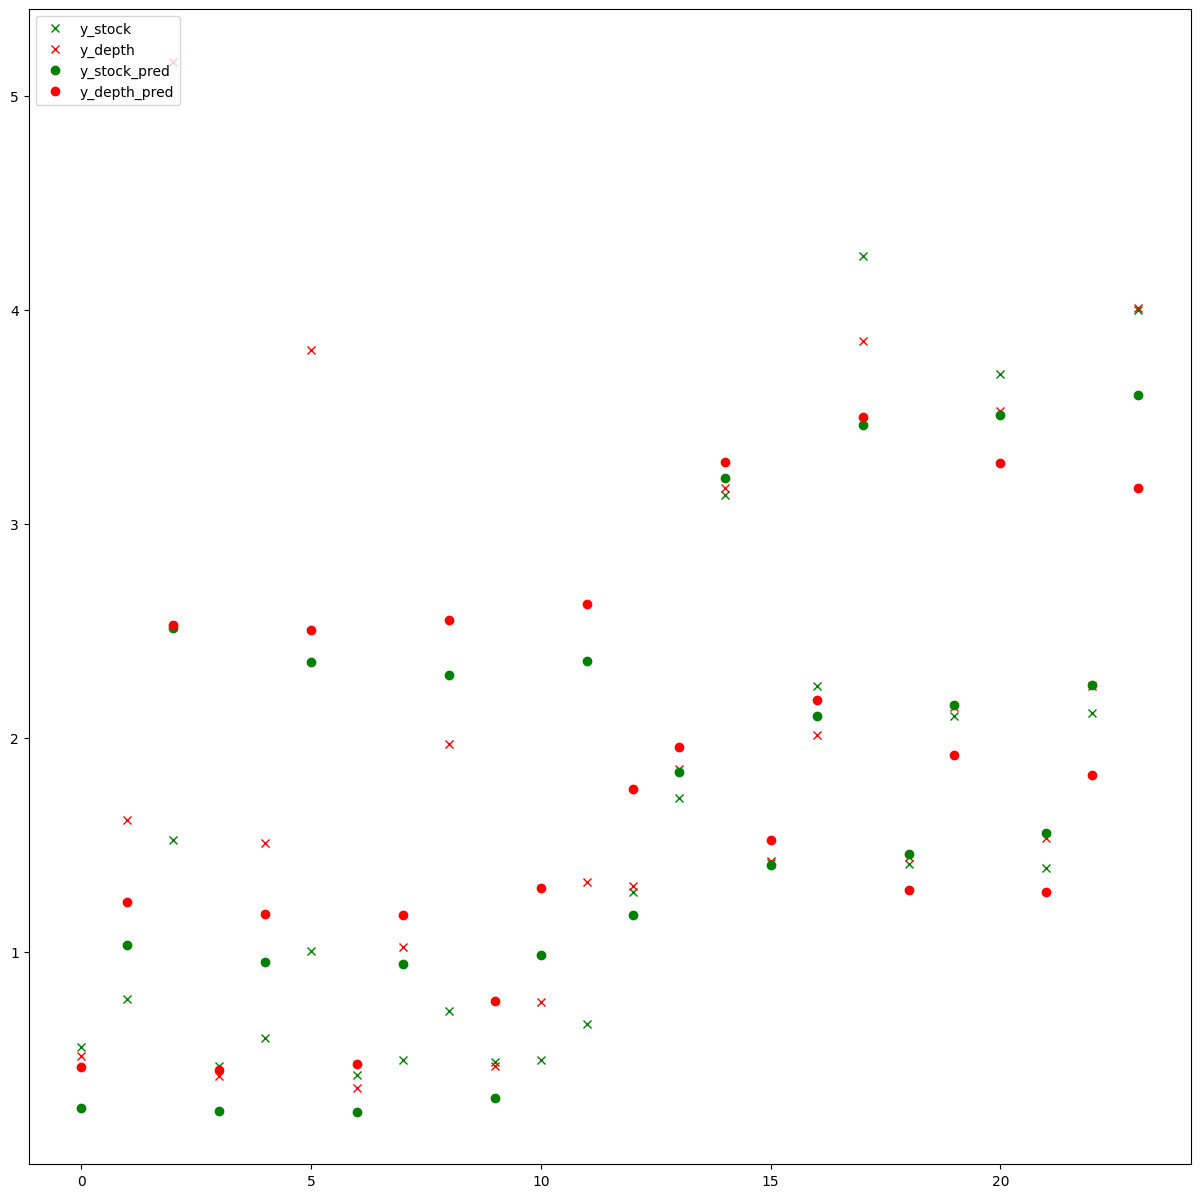

In [22]:
X_stock = final_stock_df.loc[(final_stock_df['algo'] == 'stock') & (final_stock_df['graph_type'] == 'simple')].loc[final_stock_df['nprs_mean'] <= nprs_mean_th].loc[final_stock_df['threads'].isin(threads)][X_keys].to_numpy()
y_stock = final_stock_df.loc[(final_stock_df['algo'] == 'stock') & (final_stock_df['graph_type'] == 'simple')].loc[final_stock_df['nprs_mean'] <= nprs_mean_th].loc[final_stock_df['threads'].isin(threads)][y_key].to_numpy()
X_depth = final_depth_df.loc[(final_depth_df['algo'] == 'depth') & (final_depth_df['graph_type'] == 'simple')].loc[final_depth_df['nprs_mean'] <= nprs_mean_th].loc[final_depth_df['threads'].isin(threads)][X_keys].to_numpy()
y_depth = final_depth_df.loc[(final_depth_df['algo'] == 'depth') & (final_depth_df['graph_type'] == 'simple')].loc[final_depth_df['nprs_mean'] <= nprs_mean_th].loc[final_depth_df['threads'].isin(threads)][y_key].to_numpy()

model = models[n]

y_stock_pred = model_cross.predict(X_stock)
y_depth_pred = model_cross.predict(X_depth)

xs = list(range(len(y_stock)))
plt.figure(figsize=(15, 15))
plt.plot(xs, y_stock, 'gx', label='y_stock')
plt.plot(xs, y_depth, 'rx', label='y_depth')
plt.plot(xs, y_stock_pred, 'go', label='y_stock_pred')
plt.plot(xs, y_depth_pred, 'ro', label='y_depth_pred')
plt.legend(loc="upper left")

plt.show()


In [23]:
print(df.shape)
df = df.loc[df['nprs_mean'] < x]
print(df.shape)

(92, 13)
(77, 13)


/tmp/ipykernel_457836/3822515570.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


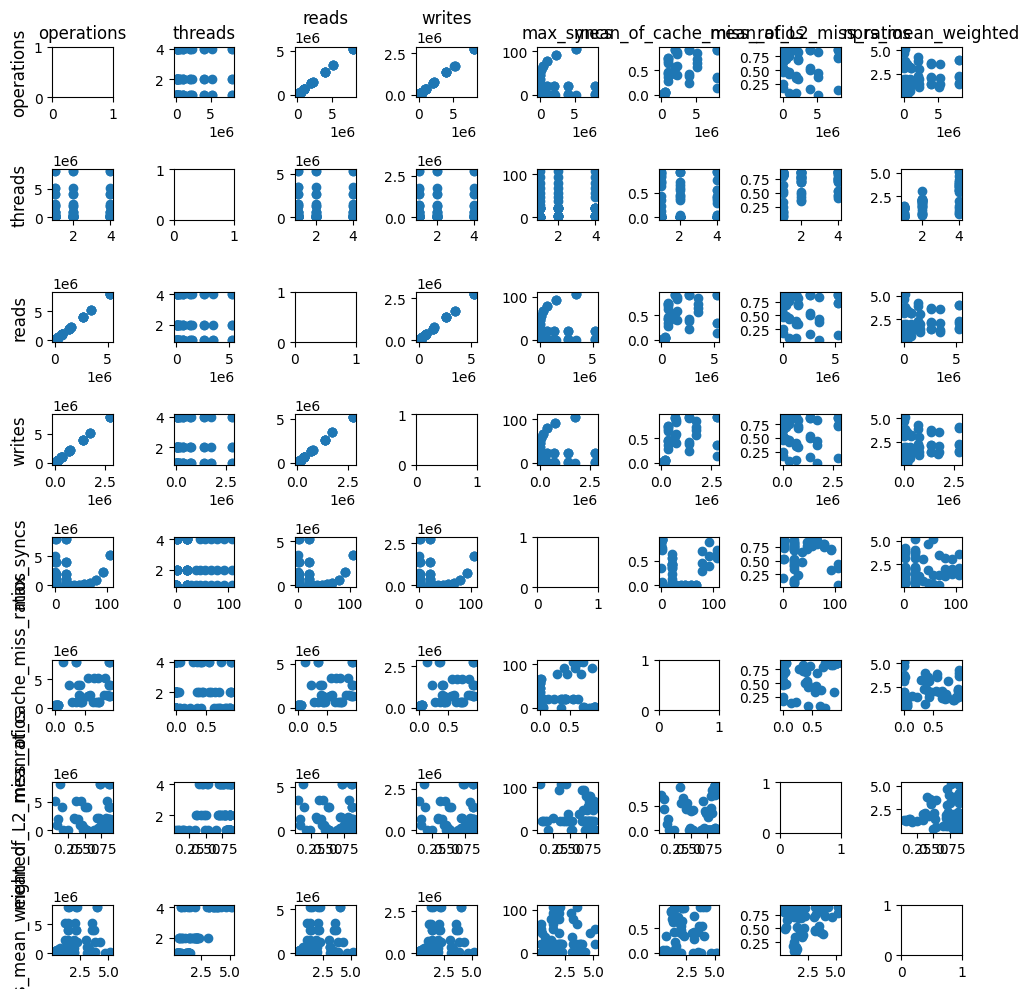

In [24]:
fig, axes = plt.subplots(len(Xy_keys), len(Xy_keys), figsize=(len(Xy_keys) * 1.25, len(Xy_keys) * 1.25))

for i in range(len(Xy_keys)):
    for j in range(len(Xy_keys)):
        if i == j:
            continue
        # i_ = i - 1 if i > j else i
        # j_ = j - 1 if j > i else j

        key1 = Xy_keys[i]
        key2 = Xy_keys[j]

        df.plot(x=key1, y=key2, style='o', ax=axes[i, j], xlabel=None, ylabel=None)
        axes[i, j].get_legend().remove()
        axes[i, j].set_ylabel(None)
        axes[i, j].set_xlabel(None)

for ax, col in zip(axes[0], Xy_keys):
    ax.set_title(col)

for ax, row in zip(axes[:, 0], Xy_keys):
    ax.set_ylabel(row, size='large')

fig.tight_layout()
fig.show()

In [25]:
# X_train = df.loc[((df['algo'] == 'stock') & (df['graph_type'] == 'simple')) | (df['graph_type'] == 'bitonic')].loc[df['nprs_mean'] <= 1.3].loc[df['threads'].isin(threads)][X_keys].to_numpy()
# y_train = df.loc[((df['algo'] == 'stock') & (df['graph_type'] == 'simple')) | (df['graph_type'] == 'bitonic')].loc[df['nprs_mean'] <= 1.3].loc[df['threads'].isin(threads)][y_key].to_numpy()

# X_test = df.loc[(df['algo'] == 'depth') & (df['graph_type'] == 'simple')].loc[df['nprs_mean'] <= 1.3].loc[df['threads'].isin(threads)][X_keys].to_numpy()
# y_test = df.loc[(df['algo'] == 'depth') & (df['graph_type'] == 'simple')].loc[df['nprs_mean'] <= 1.3].loc[df['threads'].isin(threads)][y_key].to_numpy()

# print(X_train.shape)
# print(X_test.shape)

In [26]:
df[Xy_keys].corr()

,operations,threads,reads,writes,max_syncs,mean_of_cache_miss_ratios,mean_of_L2_miss_ratios,nprs_mean_weighted
operations,1.000000,0.050771,0.999975,0.999908,0.055374,0.624308,-0.178687,0.299295
threads,0.050771,1.000000,0.050147,0.051962,0.094208,0.011577,0.142520,0.740880
reads,0.999975,0.050147,1.000000,0.999787,0.059172,0.625414,-0.179860,0.298879
writes,0.999908,0.051962,0.999787,1.000000,0.048081,0.622099,-0.176410,0.300052
max_syncs,0.055374,0.094208,0.059172,0.048081,1.000000,0.026278,-0.278091,0.234144
mean_of_cache_miss_ratios,0.624308,0.011577,0.625414,0.622099,0.026278,1.000000,-0.041041,0.302752
mean_of_L2_miss_ratios,-0.178687,0.142520,-0.179860,-0.176410,-0.278091,-0.041041,1.000000,-0.051751
nprs_mean_weighted,0.299295,0.740880,0.298879,0.300052,0.234144,0.302752,-0.051751,1.000000


In [27]:
model_smf = smf.ols(formula=y_key + ' ~ ' + ' + '.join(X_keys), data=df).fit()
print(model_smf.summary())

                            OLS Regression Results                            
Dep. Variable:     nprs_mean_weighted   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     26.76
Date:                Wed, 19 Jun 2024   Prob (F-statistic):           2.51e-16
Time:                        14:04:36   Log-Likelihood:                -81.112
No. Observations:                  77   AIC:                             176.2
Df Residuals:                      70   BIC:                             192.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [28]:
X = df[X_keys].to_numpy()
y = df[[y_key]].to_numpy()

In [29]:
model_lr = LinearRegression()
model_lr.fit(X=X, y=y)

y_pred = model_lr.predict(X)

print('MPE:', np.mean(np.abs((y_pred - y) / y)))
print('MAE:', np.mean(np.abs(y_pred - y)))
print(model_lr.coef_, model_lr.intercept_)

MPE: 0.3694239769988073
MAE: 0.44411408326541346
[[ 2.15230803e-06  7.23957551e-01 -9.07764966e-06  1.12302092e-05
   9.27921290e-03  9.77954557e-01 -5.35153414e-01]] [-0.00260227]


/home/shkiper/miniconda3/envs/pt_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=6.86011e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/shkiper/miniconda3/envs/pt_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.09138e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


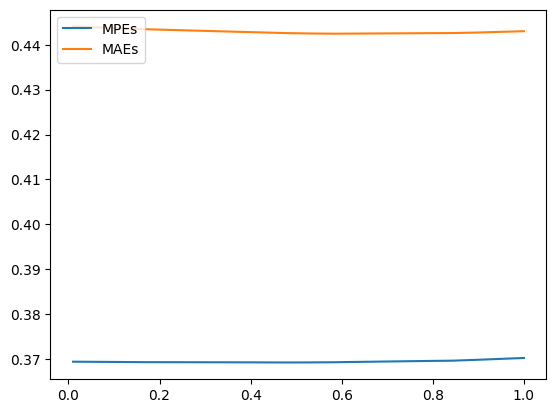

In [30]:
alphas = np.linspace(start=0.01, stop=1, num=20)
mpes = []
maes = []

for alpha in alphas:
    model_ridge = Ridge(alpha=alpha)
    model_ridge.fit(X=X, y=y)

    y_pred = model_ridge.predict(X)

    mpes.append(np.mean(np.abs((y_pred - y) / y)))
    maes.append(np.mean(np.abs((y_pred - y))))

plt.plot(alphas, mpes, label='MPEs')
plt.plot(alphas, maes, label='MAEs')
plt.legend(loc="upper left")
plt.show()


/home/shkiper/miniconda3/envs/pt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.081e+01, tolerance: 1.221e-02
  model = cd_fast.enet_coordinate_descent(
/home/shkiper/miniconda3/envs/pt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.512e+01, tolerance: 1.221e-02
  model = cd_fast.enet_coordinate_descent(
/home/shkiper/miniconda3/envs/pt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or

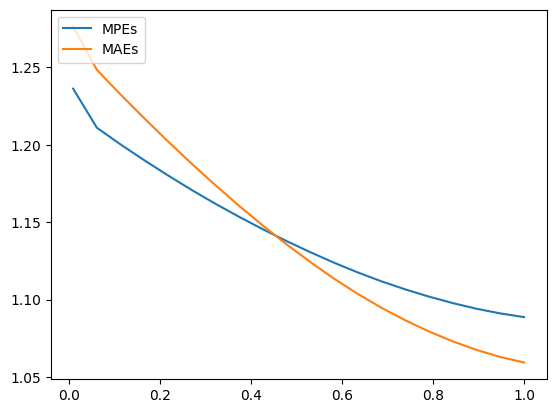

In [31]:
alphas = np.linspace(start=0.01, stop=1, num=20)
mpes = []
maes = []
for alpha in alphas:
    model_lasso = Lasso(alpha=alpha)
    model_lasso.fit(X=X, y=y)

    y_pred = model_lasso.predict(X)

    mpes.append(np.mean(np.abs((y_pred - y) / y)))
    maes.append(np.mean(np.abs((y_pred - y))))

plt.plot(alphas, mpes, label='MPEs')
plt.plot(alphas, maes, label='MAEs')
plt.legend(loc="upper left")
plt.show()

In [34]:
mpes = []
maes = []

for _ in tqdm(range(1000)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25)

    if len(mpes) == 0:
        print('train size:', len(X_train))
        print('test size:', len(X_test))

    model_lr_mlway = LinearRegression()
    model_lr_mlway.fit(X=X_train, y=y_train)

    y_pred = model_lr_mlway.predict(X_test)

    mpes.append(np.mean(np.abs((y_pred - y_test) / y_test)))
    maes.append(np.mean(np.abs((y_pred - y_test))))

print('Mean MPE:', np.mean(mpes))
print('Mean MAE:', np.mean(maes))

 23%|██▎       | 233/1000 [00:00<00:00, 1177.32it/s]

train size: 57
test size: 20


100%|██████████| 1000/1000 [00:00<00:00, 1203.75it/s]

Mean MPE: 0.42099222874726805
Mean MAE: 0.5041316938485813
